In [4]:
import wrds, datetime
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

conn = wrds.Connection()

Loading library list...
Done


# DATA COLLECTION

## SNP , RFR , Trading Days

In [5]:
query_start_date = '1990-01-01'

In [6]:
sp500_data = conn.raw_sql(f"""
SELECT
    caldt AS date,
    sprtrn AS daily_return -- Equal-Weighted Return (includes distributions) (ewretd)
FROM
    crspq.dsp500
WHERE
    caldt >= '{query_start_date}'
ORDER BY
    caldt;
""")
sp500_data['date'] = pd.to_datetime(sp500_data['date'])

sp500_data

,date,daily_return
0,1990-01-02,0.017799
1,1990-01-03,-0.002586
2,1990-01-04,-0.008613
3,1990-01-05,-0.009756
4,1990-01-08,0.004514
...,...,...
8748,2024-09-24,0.002511
8749,2024-09-25,-0.001861
8750,2024-09-26,0.004039
8751,2024-09-27,-0.001253


In [7]:
risk_free_data = conn.raw_sql(f'''
    SELECT
        date,
        rf AS daily_rf_rate -- One Month Treasury Bill Rate (daily)
    FROM
        ff.factors_daily
    WHERE
        date >= '{query_start_date}'
''')

risk_free_data['date'] = pd.to_datetime(risk_free_data['date'])

risk_free_data

,date,daily_rf_rate
0,1990-01-02,0.00026
1,1990-01-03,0.00026
2,1990-01-04,0.00026
3,1990-01-05,0.00026
4,1990-01-08,0.00026
...,...,...
8771,2024-10-25,0.00017
8772,2024-10-28,0.00017
8773,2024-10-29,0.00017
8774,2024-10-30,0.00017


In [8]:
last_trading_days = conn.raw_sql(f'''
SELECT DISTINCT
    MAX(date) AS last_trade_date
FROM crsp.dsf
WHERE date >= '{query_start_date}'
GROUP BY DATE_TRUNC('month', date)
ORDER BY last_trade_date
''')

last_trading_days['last_trade_date'] = pd.to_datetime(last_trading_days['last_trade_date'])
last_trading_days['month'] = last_trading_days['last_trade_date'].dt.month
last_trading_days['year'] = last_trading_days['last_trade_date'].dt.year
last_trading_day_mapping = last_trading_days.set_index(['year', 'month'])['last_trade_date'].to_dict()

## Choosing Companies

In [9]:
# retrieves ID (permno) and earliest recorded name for each company in CRSP database
# 37,776 companies available

comps = conn.raw_sql( '''
SELECT permno, MIN(comnam) AS company_name
FROM crsp.stocknames
GROUP BY permno
''')
comps

,permno,company_name
0,83264,GREIF BROTHERS CORP
1,63618,HINDERLITER ENERGY EQUIP CORP
2,10896,CAMILLE ST MORITZ INC
3,69906,SEIBELS BRUCE GROUP INC
4,79030,GREAT CENTRAL MINES LTD
...,...,...
37771,14886,ARK E T F TRUST
37772,79163,A M F M INC
37773,86036,BRENTWOOD INSTRUMENTS INC
37774,92970,CHINA EDUCATION ALLIANCE INC


In [10]:
#TODO: choose a way to narrow the above list of permnos to <500. Will then use that list with the following functions to gather fin data
#this will go away when the above is completed.

company_search = 'AMAZON' # FIND A COMPANY HERE

comps[comps['company_name'].str.contains(f'{company_search}')]

,permno,company_name
9682,84788,AMAZON COM INC


## Get Unique Identifiers

In [11]:
def get_gvkey(permno):
    link = conn.raw_sql(f'''
    SELECT *
    FROM crsp.ccmxpf_linktable
    WHERE lpermno = {permno};
    ''')
    
    return link['gvkey'][0]

In [12]:
# #permnos = [10107, 86580, 84788]
# # BELOW IS THE LIST OF PERMNOs FOR TEN COMPANIES

# query = """
# select distinct on (a.permno) a.permno, a.permco, a.cusip, a.comnam
# from crsp.stocknames a
# where a.comnam ilike '%%alphabet%%' and a.cusip like '02079K30'
#     or a.comnam ilike '%%amazon%%'
#     or a.comnam ilike 'apple inc%%'
#     or a.comnam ilike '%%meta platforms%%'
#     or a.comnam ilike '%%microsoft%%'
#     or a.comnam ilike '%%nvidia%%'
#     or a.comnam ilike '%%tesla inc%%'
#     or a.comnam ilike '%%netflix%%'
#     or a.comnam ilike '%%walmart%%'
#     or a.comnam ilike '%%pfizer%%'
# ;
# """

# ids = conn.raw_sql(query)
# permnos = ids['permno'].to_list()

# gvkeys = [get_gvkey(permno) for permno in permnos]
# ids['gvkey'] = gvkeys

# ids

In [13]:
query = """
SELECT *
FROM (
    SELECT DISTINCT ON (a.permno) 
        a.permno, 
        a.permco, 
        a.cusip, 
        a.comnam, 
        a.end_date, 
        a.st_date,
        a.siccd
    FROM crsp.stocknames a
    WHERE a.hexcd IN (3) and a.end_date = '2023-12-29' and a.st_date <= '2000-01-01' and (a.siccd < 6000 or a.siccd > 6799)
    ORDER BY a.permno, a.end_date DESC
) subquery
ORDER BY end_date DESC;

"""

ids = conn.raw_sql(query)
permnos = ids['permno'].to_list()

gvkeys = [get_gvkey(permno) for permno in permnos]
ids['gvkey'] = gvkeys

assert(len(gvkeys) == len(permnos))
print(f'There are {len(permnos)} companies in the list.')

ids


There are 614 companies in the list.


,permno,permco,cusip,comnam,end_date,st_date,siccd,gvkey
0,10026,7976,46603210,J & J SNACK FOODS CORP,2023-12-29,1986-02-04,2050,012825
1,10032,7980,72913210,PLEXUS CORP,2023-12-29,1986-02-05,3670,012945
2,10044,7992,77467X10,ROCKY MOUNTAIN CHOCOLATE FAC INC,2023-12-29,1986-02-11,2060,011976
3,10066,6331,35518410,ABM COMPUTER SYS,2023-12-29,1983-08-25,3573,001008
4,10107,8048,59491810,MICROSOFT CORP,2023-12-29,1986-03-13,7370,012141
...,...,...,...,...,...,...,...,...
609,88779,7343,44934S20,HOWTEK INC,2023-12-29,1984-12-13,3555,012874
610,89456,7459,50216C10,L S I LIGHTING SYS INC,2023-12-29,1985-03-12,3648,006527
611,89858,34920,72650310,PLAINS ALL AMERN PIPELINE L P,2023-12-29,1998-11-18,4619,116029
612,89915,7301,58058910,MCGRATH RENTCORP,2023-12-29,1984-11-13,5510,007161


In [14]:
chosen_index = 6

## Query Company Data

In [15]:
def get_company_financials(gvkey):
    company_fin_data = conn.raw_sql(f'''
    SELECT
        datadate AS date,
        gvkey AS gvkey,
        rdq AS reporting_date, -- Date of which information was reported
        atq AS total_assets,  -- Total Assets
        chq AS cash_holdings,  -- Cash and Short-Term Investments
        dlttq + dlcq AS total_debt,  -- Total Debt (long-term + short-term debt)
        ibq AS earnings,  -- Earnings before extraordinary items
        xrdq AS rd_expense,  -- R&D expense
        dvpq AS dividends_paid,  -- Dividends paid
        xintq AS interest_expense  -- Interest expense
    FROM
        comp.fundq
    WHERE
        gvkey = '{gvkey}'
        AND datadate >= '{query_start_date}'  -- Ensure data is after the link start date
    ''')
    
    company_fin_data['date'] = pd.to_datetime(company_fin_data['date'])
    company_fin_data['reporting_date'] = pd.to_datetime(company_fin_data['reporting_date'])
    
    return company_fin_data.dropna()

In [16]:
def make_PiT_ffill(company_fin_data):

    temp = company_fin_data.copy()
    
    #company_fin_data['month_start'] = company_fin_data['date'] - pd.offsets.MonthBegin()
    #company_fin_data['month_end'] = company_fin_data['date']

    temp['reporting_date'] = pd.to_datetime(temp['reporting_date']) + pd.Timedelta(days=1)
    temp['month'] = temp['reporting_date'].dt.month
    temp['year'] = temp['reporting_date'].dt.year
    
    temp['EOM_trade_date'] = temp.apply(
        lambda row: last_trading_day_mapping.get((row['year'], row['month'])),
        axis=1
    )
    temp.drop(columns=['date','month','year','reporting_date'], axis=1, inplace=True)
    temp.rename(columns={'EOM_trade_date':'date'}, inplace=True)
    temp = temp[temp.columns[-1:].append(temp.columns[:-1])]
    temp['date'] = pd.to_datetime(temp['date'])

    start_date = temp['date'].min()
    end_date = temp['date'].max()

    all_months = pd.date_range(start=start_date, end=end_date, freq='ME')
    full_range_df = pd.DataFrame({'date': all_months})

    temp = pd.merge(full_range_df, temp, on='date', how='left')

    temp = temp.ffill()

    temp['month_start'] = temp['date'] - pd.offsets.MonthBegin()
    temp['month_end'] = temp['date']

    return temp

In [17]:
def get_prices(permno):
    company_stock_prcs = conn.raw_sql(f'''
    SELECT
        permno,
        date,
        prc AS stock_price,
        prc * shrout AS market_cap  -- Market cap
    FROM
        crsp.dsf
    WHERE
        permno = {permno}
    ''')
    
    company_stock_prcs['date'] = pd.to_datetime(company_stock_prcs['date'])

    return company_stock_prcs

In [18]:
def get_comp_data(permno, gvkey):

    company_fin_data = make_PiT_ffill(get_company_financials(gvkey))
    company_stock_prcs = get_prices(permno)
    
    company = pd.merge(company_fin_data, company_stock_prcs, on='date', how='left').ffill()

    company['stock_return'] = company['stock_price'].pct_change()

    return company

In [19]:
# EXAMPLE USAGE

example = get_comp_data(ids['permno'][chosen_index], ids['gvkey'][chosen_index])

example

,date,gvkey,total_assets,cash_holdings,total_debt,earnings,rd_expense,dividends_paid,interest_expense,month_start,month_end,permno,stock_price,market_cap,stock_return
0,2007-08-31,012181,29.911,6.777,0.116,0.240,2.137,0.0,0.002,2007-08-01,2007-08-31,10200.0,4.3200,132282.72,NaN
1,2007-09-30,012181,29.911,6.777,0.116,0.240,2.137,0.0,0.002,2007-09-01,2007-09-30,10200.0,4.3200,132282.72,0.000000
2,2007-10-31,012181,29.911,6.777,0.116,0.240,2.137,0.0,0.002,2007-10-01,2007-10-31,10200.0,4.2525,131368.23,-0.015625
3,2007-11-30,012181,70.803,38.416,0.105,40.306,1.154,0.0,0.003,2007-11-01,2007-11-30,10200.0,4.7800,147783.26,0.124045
4,2007-12-31,012181,70.803,38.416,0.105,40.306,1.154,0.0,0.003,2007-12-01,2007-12-31,10200.0,6.5500,203410.25,0.370293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,2023-07-31,012181,2547.939,516.609,420.696,15.337,12.154,0.0,0.865,2023-07-01,2023-07-31,10200.0,171.5600,9565499.36,0.212781
194,2023-08-31,012181,2557.058,603.656,422.848,19.786,9.706,0.0,0.868,2023-08-01,2023-08-31,10200.0,173.9100,9696525.96,0.013698
195,2023-09-30,012181,2557.058,603.656,422.848,19.786,9.706,0.0,0.868,2023-09-01,2023-09-30,10200.0,173.9100,9696525.96,0.000000
196,2023-10-31,012181,2557.058,603.656,422.848,19.786,9.706,0.0,0.868,2023-10-01,2023-10-31,10200.0,134.5600,7512753.92,-0.226266


# Calculate Cash Hedged Returns

In [20]:
def calculate_b_it(company):
    data = company.copy()
    data['market_cap_t_minus_1'] = data['market_cap'].shift() # paper uses M_{t-1} for the denoms
    data['leverage'] = data['total_debt'] / (data['total_debt'] + data['market_cap'])
    
    # Y VALUES
    data['r_minus_R'] = data['stock_return'] - data['rf_rate']
    
    # REGRESSION VARIABLES
    data['gamma_1'] = (data['cash_holdings'].diff()) / data['market_cap_t_minus_1']
    data['gamma_2'] = (data['earnings'].diff()) / data['market_cap_t_minus_1']
    data['gamma_3'] = ((data['total_assets'] - data['cash_holdings']).diff()) / data['market_cap_t_minus_1']
    data['gamma_4'] = (data['rd_expense'].diff()) / data['market_cap_t_minus_1']
    data['gamma_5'] = (data['interest_expense'].diff()) / data['market_cap_t_minus_1']
    data['gamma_6'] = (data['dividends_paid'].diff()) / data['market_cap_t_minus_1']
    data['gamma_7']= data['cash_holdings_t_minus_1'] / data['market_cap_t_minus_1']
    data['gamma_8'] = data['leverage']
    data['gamma_9'] = (data['total_debt'].diff() + data['market_cap_t_minus_1'].diff()) / (data['total_debt'].shift() + data['market_cap_t_minus_1'].shift())
    data['gamma_10'] = (data['market_cap_t_minus_1'] * (data['cash_holdings'].diff())) / (data['market_cap'] ** 2)
    data['gamma_11'] = (data['leverage'] * (data['cash_holdings'].diff())) / data['market_cap']
    
    data = data.dropna()
    
    y = data['r_minus_R']
    X = data[['gamma_1', 'gamma_2', 'gamma_3', 'gamma_4', 'gamma_5', 'gamma_6', 'gamma_7', 'gamma_8', 'gamma_9', 'gamma_10', 'gamma_11']]
    
    X = sm.add_constant(X)
    
    model = sm.OLS(y, X).fit()
    
    #print(model.summary())
    
    data['marginal_cash_value'] = (
        model.params.iloc[0] +
        (model.params.iloc[10] * (data['cash_holdings_t_minus_1'] / data['market_cap_t_minus_1'])) +
        (model.params.iloc[11] * data['leverage'])
    )
    
    data['average_cash_value'] = data['marginal_cash_value'] * data['cash_holdings']
    
    company['b_it'] = data['average_cash_value'].pct_change()  # monthly cash return

In [21]:
def calculate_e_it(company):
    company['cash_hedged_return'] = (1 / (1 - company['cash_share_weight'])) * (company['stock_return'] - (company['cash_share_weight']  * company['b_it']))

In [22]:
def winsorize(series, lower=0.01, upper=0.99):
    lower_threshold = series.quantile(lower)
    upper_threshold = series.quantile(upper)
    return series.clip(lower=lower_threshold, upper=upper_threshold)

In [23]:
def calculate_returns(company):
    company['cash_share_weight'] = (company['cash_holdings'] / company['total_assets'])
    company['cash_holdings_t_minus_1'] = company['cash_holdings'].shift()
    
    calculate_b_it(company)
    calculate_e_it(company)
    
    company['cash_hedged_return'] = winsorize(company['cash_hedged_return'])

In [24]:
def calculate_rolling_beta(stock_return, market_return, window = 65):
    rolling_cov = stock_return.rolling(window).cov(market_return)
    rolling_var = market_return.rolling(window).var()
    return rolling_cov / rolling_var

# Data Aggregation

In [25]:
def main():

    agg_fin_data = pd.DataFrame(columns=['date', 'gvkey', 'reporting_date', 'total_assets', 'cash_holdings',
        'total_debt', 'earnings', 'rd_expense', 'dividends_paid',
        'interest_expense', 'stock_price', 'stock_return', 'market_cap',
        'snp_return', 'rf_rate', 'cash_share_weight', 'cash_holdings_t_minus_1',
        'b_it', 'cash_hedged_return', 'company_beta', 'cash_hedged_beta', 'comnam'])

    # Create a mapping from permno to comnam
    comnam_mapping = ids.set_index('permno')['comnam'].to_dict()

    for i in range(len(permnos)):
        try:
            # Try to get the company data
            company = get_comp_data(permnos[i], gvkeys[i])
            
            # If the company table is empty, skip it
            if company.empty:
                print(f'The {i}th company with permno {permnos[i]} has no data. Skipping...')
                continue

            # Add the company name (comnam) to the company DataFrame
            company['comnam'] = comnam_mapping.get(permnos[i], 'Unknown')
            
            def aggregate_monthly(start_date, end_date, daily_data, column, agg_func):
                mask = (daily_data['date'] >= start_date) & (daily_data['date'] <= end_date)
                return agg_func(daily_data.loc[mask, column])
            
            company['snp_return'] = company.apply(
                lambda row: aggregate_monthly(row['month_start'], row['month_end'], sp500_data, 'daily_return', 
                                            lambda x: np.prod(1 + x) - 1), axis=1
            )
            
            company['rf_rate'] = company.apply(
                lambda row: aggregate_monthly(row['month_start'], row['month_end'], risk_free_data, 'daily_rf_rate', 
                                            lambda x: np.prod(1 + x) - 1), axis=1
            )
            
            company.drop(columns=['month_start', 'month_end'], axis=1, inplace=True)
            
            calculate_returns(company)
            
            company['company_beta'] = calculate_rolling_beta(company['stock_return'], company['snp_return'])
            company['cash_hedged_beta'] = calculate_rolling_beta(company['cash_hedged_return'], company['snp_return'])
            
            if not agg_fin_data.empty:
                agg_fin_data = pd.concat([agg_fin_data, company], ignore_index=True)
            else:
                agg_fin_data = company
        except Exception as e:
            # Catch any errors, log the permno and the error, then skip
            print(f"Error with permno {permnos[i]}: {e}. Skipping...")
            continue

    agg_fin_data = agg_fin_data.sort_values(by=['comnam', 'date']).reset_index(drop=True)

    agg_fin_data = agg_fin_data[['date', 'comnam', 'gvkey', 'permno', 'stock_return', 'b_it' ,'cash_hedged_return', 'company_beta', 'cash_hedged_beta', 'snp_return', 'rf_rate']].dropna()

    return agg_fin_data.reset_index(drop=True)

out = main()

out

Error with permno 10026: zero-size array to reduction operation maximum which has no identity. Skipping...
Error with permno 10032: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 10044: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 10066: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 10257: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 10258: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 10355: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 10397: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 10421: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 10443: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 10501: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 10649: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 10812: Neither `start` nor `end` can be NaT. Skipp

/var/folders/r1/cc6f_cms7gs0mjjnvtnzdmcm0000gn/T/ipykernel_40153/540243409.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  company['stock_return'] = company['stock_price'].pct_change()


Error with permno 11275: zero-size array to reduction operation maximum which has no identity. Skipping...


/var/folders/r1/cc6f_cms7gs0mjjnvtnzdmcm0000gn/T/ipykernel_40153/540243409.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  company['stock_return'] = company['stock_price'].pct_change()


Error with permno 11511: zero-size array to reduction operation maximum which has no identity. Skipping...
Error with permno 11701: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 11790: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 11884: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 11995: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 12209: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 15070: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 16505: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 17137: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 19271: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 19502: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 19828: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 20598: Neither `start` nor `end` can be NaT. Skipp

/var/folders/r1/cc6f_cms7gs0mjjnvtnzdmcm0000gn/T/ipykernel_40153/540243409.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  company['stock_return'] = company['stock_price'].pct_change()


Error with permno 78988: zero-size array to reduction operation maximum which has no identity. Skipping...
Error with permno 79033: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 79249: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 79666: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 79841: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 79857: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 79864: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 79866: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 79878: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 79903: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 80034: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 80072: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 80179: Neither `start` nor `end` can be NaT. Skipp

/var/folders/r1/cc6f_cms7gs0mjjnvtnzdmcm0000gn/T/ipykernel_40153/540243409.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  company['stock_return'] = company['stock_price'].pct_change()


Error with permno 86092: zero-size array to reduction operation maximum which has no identity. Skipping...
Error with permno 86144: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 86158: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 86165: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 86728: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 86783: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 86812: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 86827: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 86887: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 86916: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 86996: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 87055: Neither `start` nor `end` can be NaT. Skipping...
Error with permno 87077: Neither `start` nor `end` can be NaT. Skipp

,date,comnam,gvkey,permno,stock_return,b_it,cash_hedged_return,company_beta,cash_hedged_beta,snp_return,rf_rate
0,2014-07-31,A P A OPTICS INC,012482,10547.0,-0.233472,-0.063696,-0.334163,0.487251,0.875968,-0.015080,0.000000
1,2014-08-31,A P A OPTICS INC,012482,10547.0,0.000000,0.309162,-0.183358,0.480359,0.817720,0.037655,0.000000
2,2014-09-30,A P A OPTICS INC,012482,10547.0,-0.010878,0.000000,-0.017330,0.434812,0.724377,-0.015513,0.000000
3,2014-10-31,A P A OPTICS INC,012482,10547.0,0.153181,-0.011199,0.250672,0.475890,0.785377,0.023202,0.000000
4,2014-11-30,A P A OPTICS INC,012482,10547.0,0.000000,-0.134376,0.079696,0.539251,0.897727,0.024535,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
38577,2023-07-31,ZENECA GROUP PLC,028272,79363.0,0.001816,-0.064096,0.005924,0.388708,0.341801,0.031139,0.004409
38578,2023-08-31,ZENECA GROUP PLC,028272,79363.0,-0.054114,0.057364,-0.061062,0.397753,0.351835,-0.017717,0.004610
38579,2023-09-30,ZENECA GROUP PLC,028272,79363.0,0.000000,-0.000060,0.000004,0.396427,0.351252,-0.048720,0.004208
38580,2023-10-31,ZENECA GROUP PLC,028272,79363.0,-0.067679,0.072646,-0.076425,0.405793,0.361662,-0.021980,0.004630


In [26]:
# look at the number of unique permnos in agg_fin_data
print(f"Number of companies initially was {len(permnos)} but we could only get the data of {len(out['gvkey'].unique())} companies.")

Number of companies initially was 614 but we could only get the data of 359 companies.


In [35]:
# look at the earliest date of data for each company
out.groupby('comnam')['date'].min()
# look at the earliest 50 dates ever
out['date'].sort_values().unique()[:100]
# look at average snp_return
(1+out['snp_return'].mean())**12 - 1

0.1180447288734301

## Correlation Calculation

In [28]:
input_table = out[['date', 'gvkey',  'stock_return', 'b_it', 'cash_hedged_return']]
input_table = input_table.sort_values(by=['date'])
# remove any date where b_it or cash_hedged_return is NaN
input_table = input_table.dropna(subset=['b_it', 'cash_hedged_return', 'stock_return'])
# only keep one row per combination of date and gvkey
input_table = input_table.drop_duplicates(subset=['date', 'gvkey'], keep='first')
len(input_table)
input_table[:5]

,date,gvkey,stock_return,b_it,cash_hedged_return
8519,2009-07-31,029901,0.018460,0.061462,0.002959
8520,2009-08-31,029901,0.000850,0.013368,-0.003663
8521,2009-09-30,029901,-0.060272,0.103510,-0.119308
8522,2009-10-31,029901,0.000000,-0.045535,0.016413
8523,2009-11-30,029901,-0.023788,0.037742,-0.045967


In [29]:
import pandas as pd
import numpy as np
import random

def compute_random_correlations(data, compute_on='stock_return', num_iterations=1000):
    """
    Compute pairwise correlations between two randomly chosen companies over time, 
    based on stock returns or cash returns, a specified number of times.

    Parameters:
    - data (pd.DataFrame): A DataFrame with columns ['date', 'cash_return', 'stock_return', 'gvkey'].
    - compute_on (str): Column to compute correlations on ('stock_return', 'cash_return', or 'cash_hedged_return').
    - num_iterations (int): Number of random pairs to compute correlations for.

    Returns:
    - correlations (list): A list of computed correlation values.
    """

    # Pivot data for the chosen column (stock_return, cash_return, or cash_hedged_return)
    pivot_data = data.pivot(index='date', columns='gvkey', values=compute_on)

    # Drop rows with all NaN values
    pivot_data = pivot_data.dropna(how='all')

    # print(pivot_data)

    # List of unique companies (gvkeys)
    companies = pivot_data.columns.tolist()

    # print(companies)

    # Initialize a list to store correlation results
    correlations = []

    # Perform random pair correlation computation
    for _ in range(num_iterations):
        # Randomly choose two different companies
        company1, company2 = random.sample(companies, 2)

        # Extract their returns
        series1 = pivot_data[company1]
        series2 = pivot_data[company2]

        # print(series1)
        # print(series2)

        # Align the two series by index (date) and drop rows with NaN
        aligned_series = pd.concat([series1, series2], axis=1).dropna()

        # Compute the correlation if there is sufficient data
        if len(aligned_series) > 1:  # Correlation requires at least two data points
            correlation = aligned_series.corr().iloc[0, 1]  # Correlation between company1 and company2
            correlations.append(correlation)

    return correlations

# Compute correlations based on stock returns
stock_correlations = compute_random_correlations(input_table, compute_on='stock_return', num_iterations=10000)
stock_correlations = [c for c in stock_correlations if pd.notnull(c)]
print(len(stock_correlations))

# Compute correlations based on cash returns
cash_correlations = compute_random_correlations(input_table, compute_on='b_it', num_iterations=10000)
cash_correlations = [c for c in cash_correlations if pd.notnull(c)]
print(len(cash_correlations))

# Compute correlations based on cash-hedged returns
cash_hedged_correlations = compute_random_correlations(input_table, compute_on='cash_hedged_return', num_iterations=10000)
cash_hedged_correlations = [c for c in cash_hedged_correlations if pd.notnull(c)]
print(len(cash_hedged_correlations))

# Display summary statistics
print(f"Stock Return Correlation - Mean: {np.mean(stock_correlations):.3f}, Std Dev: {np.std(stock_correlations):.3f}")
print(f"Cash Return Correlation - Mean: {np.mean(cash_correlations):.3f}, Std Dev: {np.std(cash_correlations):.3f}")
print(f"Cash Hedged Return Correlation - Mean: {np.mean(cash_hedged_correlations):.3f}, Std Dev: {np.std(cash_hedged_correlations):.3f}")


9737
9756
9728
Stock Return Correlation - Mean: 0.166, Std Dev: 0.239
Cash Return Correlation - Mean: 0.017, Std Dev: 0.224
Cash Hedged Return Correlation - Mean: 0.116, Std Dev: 0.224


In [30]:
import pandas as pd
import numpy as np

def compute_overall_correlation(data, compute_on='stock_return'):
    """
    Compute the overall average pairwise correlation across all companies based on the specified return type.

    Parameters:
    - data (pd.DataFrame): A DataFrame with columns ['date', 'cash_return', 'stock_return', 'gvkey'].
    - compute_on (str): Column to compute correlations on ('stock_return', 'cash_return', or 'cash_hedged_return').

    Returns:
    - avg_correlation (float): The average pairwise correlation across all companies.
    - std_dev_correlation (float): The standard deviation of the pairwise correlations.
    """

    # Pivot data for the chosen column (stock_return, cash_return, or cash_hedged_return)
    pivot_data = data.pivot(index='date', columns='gvkey', values=compute_on)

    # Drop rows with all NaN values
    pivot_data = pivot_data.dropna(how='all')

    # Compute the pairwise correlation matrix
    correlation_matrix = pivot_data.corr()

    # Extract the upper triangle of the correlation matrix (excluding the diagonal)
    upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

    # Flatten the upper triangle into a 1D array and drop NaN values
    pairwise_correlations = upper_triangle.unstack().dropna()

    # Compute the mean and standard deviation of the correlations
    avg_correlation = pairwise_correlations.mean()
    std_dev_correlation = pairwise_correlations.std()

    return avg_correlation, std_dev_correlation

# Compute overall correlations for stock returns
stock_avg_corr, stock_std_corr = compute_overall_correlation(input_table, compute_on='stock_return')

# Compute overall correlations for cash returns
cash_avg_corr, cash_std_corr = compute_overall_correlation(input_table, compute_on='b_it')

# Compute overall correlations for cash-hedged returns
cash_hedged_avg_corr, cash_hedged_std_corr = compute_overall_correlation(input_table, compute_on='cash_hedged_return')

# Display summary statistics
print(f"Stock Return Correlation - Mean: {stock_avg_corr:.3f}, Std Dev: {stock_std_corr:.3f}")
print(f"Cash Return Correlation - Mean: {cash_avg_corr:.3f}, Std Dev: {cash_std_corr:.3f}")
print(f"Cash Hedged Return Correlation - Mean: {cash_hedged_avg_corr:.3f}, Std Dev: {cash_hedged_std_corr:.3f}")

Stock Return Correlation - Mean: 0.165, Std Dev: 0.238
Cash Return Correlation - Mean: 0.017, Std Dev: 0.226
Cash Hedged Return Correlation - Mean: 0.115, Std Dev: 0.225


## PORTFOLIO

In [39]:
data = out.copy()
sort_criteria = 'stock_return'
is_lowest = False # do we want the lowest top percentage according to the sort criteria or the highest (false for highest)
top_percentage = 10
number_of_companies = len(out['gvkey'].unique())
starting_money = 100
start_date = '2009-12-31'
end_date = '2023-12-31'

        date  monthly_return  cumulative_return  snp_monthly_return  \
0 2009-12-31        0.129550           1.001295            0.017769   
1 2010-01-31        0.000000           1.001295           -0.036973   
2 2010-02-28        0.000000           1.001295            0.028512   
3 2010-03-31       -0.027854           1.001017            0.058798   
4 2010-04-30        0.002528           1.001042            0.014759   
5 2010-05-31        0.000000           1.001042           -0.081975   
6 2010-06-30        0.003362           1.001076           -0.053883   
7 2010-07-31        0.000000           1.001076            0.068779   
8 2010-08-31        0.016529           1.001241           -0.047449   
9 2010-09-30        0.158537           1.002828            0.087553   

   snp_cumulative_return  
0               1.017769  
1               0.980139  
2               1.008085  
3               1.067358  
4               1.083111  
5               0.994323  
6               0.940746  
7 

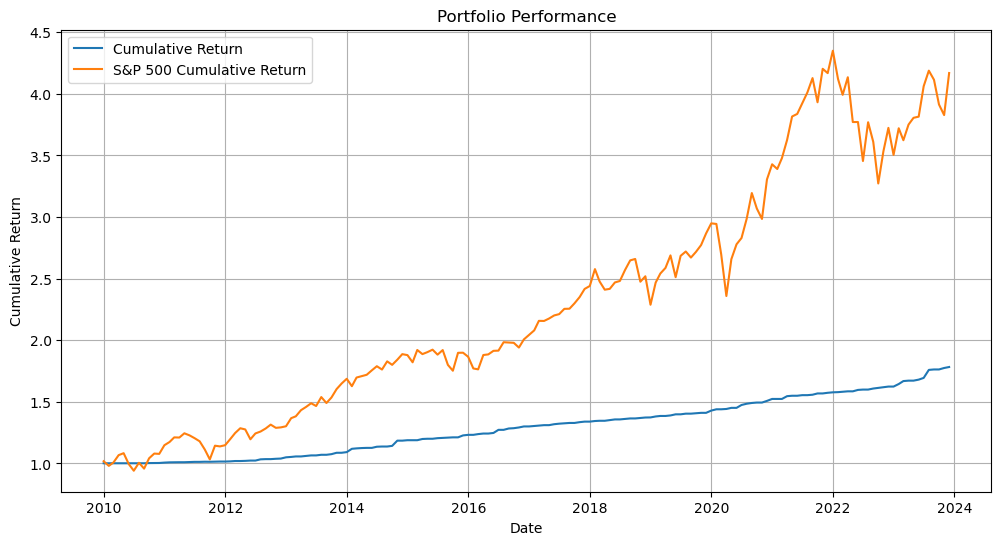

In [45]:
# Preparing the data
data['date'] = pd.to_datetime(data['date'])
data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]

# Get unique months
unique_months = data['date'].sort_values().unique()

# Portfolio simulation
current_money = starting_money
current_snp_money = starting_money
monthly_returns = []

for month in unique_months:
    # Filter data for the current month
    monthly_data = data[data['date'] == month]
    
    # Sort by criteria
    sorted_data = monthly_data.sort_values(by=sort_criteria, ascending=is_lowest)
    
    # Select top percentage of companies
    top_count = max(1, int(len(sorted_data) * top_percentage / 100))
    selected_companies = sorted_data.iloc[:top_count]
    
    # Equal weight per company
    weight = 1 / top_count
    
    # Calculate monthly return for the portfolio
    portfolio_return = (selected_companies['stock_return'] * weight).sum()
    snp_return = selected_companies['snp_return'].mean()

    # Update current money
    current_money = current_money * (1 + portfolio_return/100)
    current_snp_money = current_snp_money * (1 + snp_return)
    
    # Store monthly return and cumulative return
    monthly_returns.append({
        'date': month,
        'monthly_return': portfolio_return,
        'cumulative_return': current_money / starting_money,
        'snp_monthly_return': snp_return,
        'snp_cumulative_return': current_snp_money / starting_money
    })

# Convert results to a DataFrame
results = pd.DataFrame(monthly_returns)

# Display results
print(results.head(10))

# Plotting results
plt.figure(figsize=(12, 6))
plt.plot(results['date'], results['cumulative_return'], label='Cumulative Return')
plt.plot(results['date'], results['snp_cumulative_return'], label='S&P 500 Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Portfolio Performance')
plt.legend()
plt.grid(True)
plt.show()
